# Monte Carlo Reliability Simulation (Weibull) — Architectures + Early-Life Death + Variable Life Expectancy

This notebook simulates system failure times using Monte Carlo sampling of **component lifetimes** and then applies **system architecture rules** to compute system-level:

- Reliability curve:  \( R(t) \approx \frac{1}{N}\sum_{i=1}^N \mathbf{1}[T_i > t] \)
- MTTF: \( \mathbb{E}[T] \approx \frac{1}{N}\sum_{i=1}^N T_i \)

## What you can model
### 1) “Normal aging” (Weibull with \(\beta > 1\))
Increasing hazard (wear-out).

### 2) “Early-life deaths / infant mortality” (Weibull with \(\beta < 1\))
Decreasing hazard (high early failure rate that decreases over time).

### 3) Variable life expectancy (heterogeneity)
Randomize the Weibull scale parameter \(\eta\) across units (e.g., LogNormal).

### 4) Mixture model (weak + normal subpopulations)
A fraction of units are “weak” and fail early, the rest are normal.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Tuple, List, Callable

np.random.seed(123)


## Weibull sampling utilities
We use inverse transform sampling:

If \(U \sim \mathcal{U}(0,1)\), then for Weibull(\(\beta,\eta\)):

\[
T = \eta \left(-\ln(U)\right)^{1/\beta}
\]


In [2]:
def sample_weibull(beta: float, eta: float, size: int) -> np.ndarray:
    """Sample T ~ Weibull(beta, eta)."""
    if beta <= 0 or eta <= 0:
        raise ValueError("Weibull parameters must be positive.")
    u = np.random.rand(size)
    return eta * (-np.log(u)) ** (1.0 / beta)


def sample_weibull_random_eta(beta: float, eta_median: float, eta_sigma: float, size: int) -> np.ndarray:
    """
    Variable life expectancy via heterogeneity:
      eta ~ LogNormal(log(eta_median), eta_sigma)
      T | eta ~ Weibull(beta, eta)
    """
    if eta_median <= 0 or eta_sigma < 0:
        raise ValueError("eta_median must be >0 and eta_sigma must be >=0.")
    eta = np.random.lognormal(mean=np.log(eta_median), sigma=eta_sigma, size=size)
    u = np.random.rand(size)
    return eta * (-np.log(u)) ** (1.0 / beta)


def sample_weibull_mixture(size: int,
                           p_weak: float,
                           beta_weak: float, eta_weak: float,
                           beta_norm: float, eta_norm: float) -> np.ndarray:
    """Two-population mixture: weak (early death) vs normal."""
    if not (0 <= p_weak <= 1):
        raise ValueError("p_weak must be in [0,1].")
    is_weak = np.random.rand(size) < p_weak
    u = np.random.rand(size)
    t = np.empty(size, dtype=float)

    t[is_weak] = eta_weak * (-np.log(u[is_weak])) ** (1.0 / beta_weak)
    t[~is_weak] = eta_norm * (-np.log(u[~is_weak])) ** (1.0 / beta_norm)
    return t


## System architectures (failure-time rules)

Let component failure times be \(T_1,\dots,T_n\). Then:

- **Series**: system fails at first component failure \(\min T_i\)
- **Parallel**: system fails when all have failed \(\max T_i\)
- **k-out-of-n**: system fails at the \((n-k+1)\)-th component failure time

Composite architectures implemented here:
- **Series–Parallel**: (A‖B) in series with (C‖D)
- **Parallel–Series**: (A–B) in parallel with (C–D)


In [3]:
def sys_time_series(stack: np.ndarray) -> np.ndarray:
    """stack shape: (n_components, n_runs)."""
    return np.min(stack, axis=0)

def sys_time_parallel(stack: np.ndarray) -> np.ndarray:
    return np.max(stack, axis=0)

def sys_time_k_out_of_n(stack: np.ndarray, k: int) -> np.ndarray:
    n = stack.shape[0]
    if not (1 <= k <= n):
        raise ValueError("k must satisfy 1 <= k <= n")
    sorted_times = np.sort(stack, axis=0)
    idx = (n - k)  # zero-based index of (n-k+1)-th failure
    return sorted_times[idx, :]

def sys_time_series_parallel(stack_block1: np.ndarray, stack_block2: np.ndarray) -> np.ndarray:
    # blocks are parallel, then blocks in series => min(max(block1), max(block2))
    t1 = np.max(stack_block1, axis=0)
    t2 = np.max(stack_block2, axis=0)
    return np.minimum(t1, t2)

def sys_time_parallel_series(stack_string1: np.ndarray, stack_string2: np.ndarray) -> np.ndarray:
    # strings are series, then strings in parallel => max(min(string1), min(string2))
    t1 = np.min(stack_string1, axis=0)
    t2 = np.min(stack_string2, axis=0)
    return np.maximum(t1, t2)


## Reliability curve and MTTF estimators
We estimate:

- \( R(t) = \mathbb{P}(T_{sys} > t) \) empirically over a time grid
- \( \text{MTTF} = \mathbb{E}[T_{sys}] \) as the sample mean


In [4]:
def reliability_curve(sys_times: np.ndarray, t_grid: np.ndarray) -> np.ndarray:
    return np.mean(sys_times[None, :] > t_grid[:, None], axis=1)

def mttf(sys_times: np.ndarray) -> float:
    return float(np.mean(sys_times))


## Choose a lifetime model
Pick one of these and use it to generate component arrays.

- **Normal aging**: `sample_weibull(beta>1, eta, N)`
- **Early-life deaths**: `sample_weibull(beta<1, eta, N)`
- **Variable life expectancy**: `sample_weibull_random_eta(beta, eta_median, eta_sigma, N)`
- **Mixture (weak + normal)**: `sample_weibull_mixture(N, p_weak, ...)`


In [5]:
# Simulation settings
N = 200_000  # Monte Carlo runs (increase for smoother curves)
t_grid = np.linspace(0, 6000, 400)  # time grid for R(t)

# ---- Example lifetime models (edit these) ----
# Normal aging (β>1)
NORMAL = dict(beta=2.2, eta=2500.0)

# Infant mortality (β<1)
INFANT = dict(beta=0.7, eta=1200.0)

# Variable life expectancy (random η)
HETERO = dict(beta=2.0, eta_median=2200.0, eta_sigma=0.35)

# Mixture: p_weak early-death units + normal units
MIX = dict(
    p_weak=0.08,
    beta_weak=0.6, eta_weak=180.0,
    beta_norm=2.2, eta_norm=2500.0
)

def make_component_times(model: str, N: int) -> np.ndarray:
    if model == "normal":
        return sample_weibull(NORMAL["beta"], NORMAL["eta"], N)
    if model == "infant":
        return sample_weibull(INFANT["beta"], INFANT["eta"], N)
    if model == "hetero":
        return sample_weibull_random_eta(HETERO["beta"], HETERO["eta_median"], HETERO["eta_sigma"], N)
    if model == "mixture":
        return sample_weibull_mixture(
            N, MIX["p_weak"],
            MIX["beta_weak"], MIX["eta_weak"],
            MIX["beta_norm"], MIX["eta_norm"],
        )
    raise ValueError("Unknown model: choose 'normal', 'infant', 'hetero', or 'mixture'.")

# Choose model here:
LIFETIME_MODEL = "mixture"  # <-- change to: normal / infant / hetero / mixture


## Run all architectures with the chosen lifetime model
We’ll simulate the same component distribution for simplicity (i.i.d.).
If you want different components, you can generate A, B, C… with different parameters.


In [6]:
# Generate component lifetimes for architectures
A = make_component_times(LIFETIME_MODEL, N)
B = make_component_times(LIFETIME_MODEL, N)
C = make_component_times(LIFETIME_MODEL, N)
D = make_component_times(LIFETIME_MODEL, N)

# Series: A-B-C-D
stack_4 = np.vstack([A, B, C, D])
T_series = sys_time_series(stack_4)

# Parallel: A||B||C||D
T_parallel = sys_time_parallel(stack_4)

# Series–Parallel: (A||B) in series with (C||D)
block1 = np.vstack([A, B])
block2 = np.vstack([C, D])
T_series_parallel = sys_time_series_parallel(block1, block2)

# Parallel–Series: (A-B) in parallel with (C-D)
string1 = np.vstack([A, B])
string2 = np.vstack([C, D])
T_parallel_series = sys_time_parallel_series(string1, string2)

# 2-out-of-3 voters: A, B, C with k=2
stack_3 = np.vstack([A, B, C])
T_2oo3 = sys_time_k_out_of_n(stack_3, k=2)

# Compute reliability curves + MTTF
systems = {
    "Series (A-B-C-D)": T_series,
    "Parallel (A||B||C||D)": T_parallel,
    "Series–Parallel (A||B)-(C||D)": T_series_parallel,
    "Parallel–Series (A-B)||(C-D)": T_parallel_series,
    "2-out-of-3 voters (k=2,n=3)": T_2oo3,
}

results = {}
for name, T in systems.items():
    results[name] = {
        "mttf": mttf(T),
        "R": reliability_curve(T, t_grid),
    }

# Print MTTF summary
for name in results:
    print(f"{name:35s}  MTTF ≈ {results[name]['mttf']:.2f}")


Series (A-B-C-D)                     MTTF ≈ 901.59
Parallel (A||B||C||D)                MTTF ≈ 3284.26
Series–Parallel (A||B)-(C||D)        MTTF ≈ 2139.06
Parallel–Series (A-B)||(C-D)         MTTF ≈ 1904.25
2-out-of-3 voters (k=2,n=3)          MTTF ≈ 2022.48


## Plot reliability curves
You can switch `LIFETIME_MODEL` above to compare early-life vs normal aging vs heterogeneity.


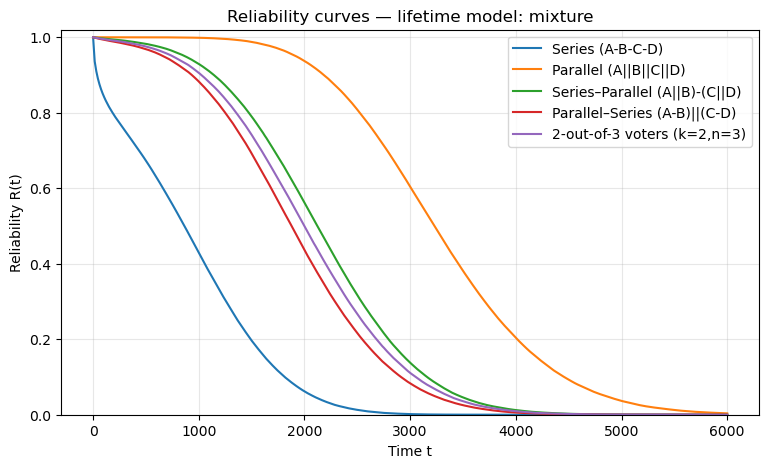

In [7]:
plt.figure(figsize=(9, 5))
for name in results:
    plt.plot(t_grid, results[name]["R"], label=name)
plt.xlabel("Time t")
plt.ylabel("Reliability R(t)")
plt.title(f"Reliability curves — lifetime model: {LIFETIME_MODEL}")
plt.ylim(0, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Compare lifetime models quickly
This cell runs the same architecture set for multiple lifetime models so you can **see infant mortality knees** and **heterogeneity effects**.


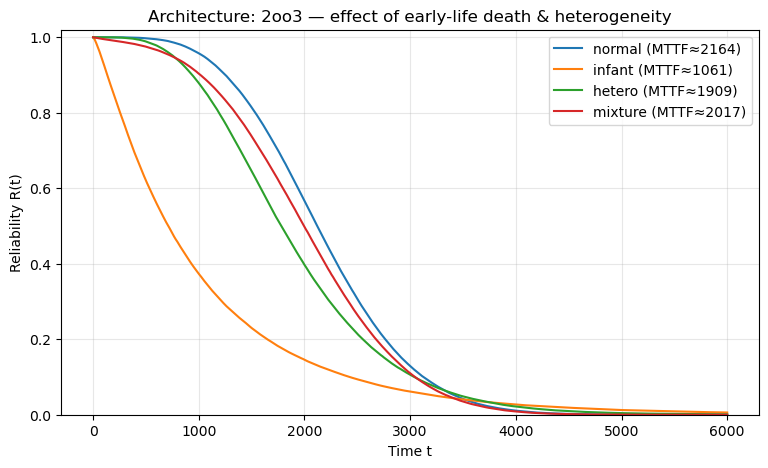

In [12]:
def run_all_architectures(model: str, N: int, t_grid: np.ndarray):
    A = make_component_times(model, N)
    B = make_component_times(model, N)
    C = make_component_times(model, N)
    D = make_component_times(model, N)

    stack_4 = np.vstack([A, B, C, D])
    block1 = np.vstack([A, B])
    block2 = np.vstack([C, D])
    string1 = np.vstack([A, B])
    string2 = np.vstack([C, D])
    stack_3 = np.vstack([A, B, C])

    systems = {
        "Series": sys_time_series(stack_4),
        "Parallel": sys_time_parallel(stack_4),
        "Series–Parallel": sys_time_series_parallel(block1, block2),
        "Parallel–Series": sys_time_parallel_series(string1, string2),
        "2oo3": sys_time_k_out_of_n(stack_3, k=2),
    }

    out = {}
    for name, T in systems.items():
        out[name] = (mttf(T), reliability_curve(T, t_grid))
    return out

models_to_compare = ["normal", "infant", "hetero", "mixture"]
arch_to_plot = "2oo3"  # choose: Series / Parallel / Series–Parallel / Parallel–Series / 2oo3

plt.figure(figsize=(9, 5))
for model in models_to_compare:
    out = run_all_architectures(model, N=120_000, t_grid=t_grid)
    m, R = out[arch_to_plot]
    plt.plot(t_grid, R, label=f"{model} (MTTF≈{m:.0f})")

plt.xlabel("Time t")
plt.ylabel("Reliability R(t)")
plt.title(f"Architecture: {arch_to_plot} — effect of early-life death & heterogeneity")
plt.ylim(0, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Notes for your thesis text (short)
- **Early-life deaths**: modeled by Weibull **β < 1** (decreasing hazard), or by a **mixture** where a fraction \(p\) belongs to a weak subpopulation.
- **Variable life expectancy**: modeled by making \(\eta\) random (e.g., lognormal), capturing unit-to-unit variability.
- The **architecture rule** is applied after sampling component lifetimes, which isolates *physics/statistics* (lifetime model) from *system design* (series/parallel/…).
